In [11]:
from keras.applications import ResNet50
INPUT_SHAPE = (256, 512, 3)

trained_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

/home/ktdiedrich/.conda/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
trained_resnet.trainable = False
print(trained_resnet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [26]:
trained_resnet.trainable = True
set_trainable = False
for layer in trained_resnet.layers:
    if layer.name == 'activation_146':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
print(trained_resnet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
base_dir = '/home/ktdiedrich/Documents/localData/RadiologyImages/LIDC-IDRI/slice_images'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')


batch_size = 25
permute_range = 0.015
# Traning generator permutes training data to add variety 
train_datagen = ImageDataGenerator(rescale=1.0/255,
    rotation_range = 20,
    width_shift_range=permute_range,
    height_shift_range=permute_range,
    shear_range=permute_range,
    zoom_range=permute_range,
    horizontal_flip=False,
    fill_mode='constant')

test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=INPUT_SHAPE[0:2], 
                                                    batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=INPUT_SHAPE[0:2],
                                                       batch_size=batch_size, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=INPUT_SHAPE[0:2],
                                                       batch_size=batch_size, class_mode='categorical')
class_number = np.unique(train_generator.classes).shape[0]

Found 2329 images belonging to 4 classes.
Found 654 images belonging to 4 classes.
Found 361 images belonging to 4 classes.


In [28]:
from keras import models, layers
from keras import optimizers, callbacks, regularizers
weight_coef = 0.01

regulator = regularizers.l2(weight_coef)
model = models.Sequential()
model.add(trained_resnet)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regulator))
model.add(layers.Dense(class_number, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    

In [29]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 16, 2048)       23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               134218240 
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 157,808,004
Trainable params: 135,275,012
Non-trainable params: 22,532,992
_________________________________________________________________
None


In [30]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='acc', patience=5)    
]
history = model.fit_generator(
    train_generator, steps_per_epoch=90, epochs=60, validation_data=validation_generator, 
    validation_steps=28, callbacks=callbacks_list)


Epoch 1/60
90/90 [==============================] - 72s 796ms/step - loss: 11.5194 - acc: 0.6061 - val_loss: 12.8563 - val_acc: 0.3051
Epoch 2/60
90/90 [==============================] - 55s 606ms/step - loss: 7.2377 - acc: 0.5921 - val_loss: 8.4509 - val_acc: 0.3163
Epoch 3/60
90/90 [==============================] - 54s 601ms/step - loss: 4.7235 - acc: 0.7137 - val_loss: 10.3293 - val_acc: 0.3140
Epoch 4/60
90/90 [==============================] - 54s 600ms/step - loss: 0.6248 - acc: 0.9640 - val_loss: 11.1481 - val_acc: 0.3110
Epoch 5/60
90/90 [==============================] - 55s 617ms/step - loss: 0.5523 - acc: 0.9720 - val_loss: 9.5092 - val_acc: 0.3036
Epoch 6/60
90/90 [==============================] - 54s 602ms/step - loss: 0.9224 - acc: 0.9444 - val_loss: 8.3466 - val_acc: 0.3274
Epoch 7/60
90/90 [==============================] - 55s 615ms/step - loss: 0.5694 - acc: 0.9676 - val_loss: 6.7462 - val_acc: 0.2426
Epoch 8/60
90/90 [==============================] - 53s 594ms/ste

In [31]:
def plot_acc_val(history):
    import matplotlib.pyplot as plt
    hkeys = history.history.keys()
    if 'acc' in hkeys:
        plt.figure()
        acc = history.history['acc']
        plt.title('Accuracy')
        epochs = range(1, len(acc)+1)
        plt.plot(epochs, acc, 'bo', label='Training acc')
        if 'val_acc' in hkeys:
            val_acc = history.history['val_acc']
            plt.plot(epochs, val_acc, 'g', label='Validation acc')
        plt.legend()
    
    if 'loss' in hkeys:
        plt.figure()
        loss = history.history['loss']
        epochs = range(1, len(loss)+1)
        plt.title('Loss')
        plt.plot(epochs, loss, 'bo', label='Training loss')
        if 'val_loss' in hkeys:
            val_loss = history.history['val_loss']
            plt.plot(epochs, val_loss, 'g', label='Validation loss')
        plt.legend()
    plt.show()
    

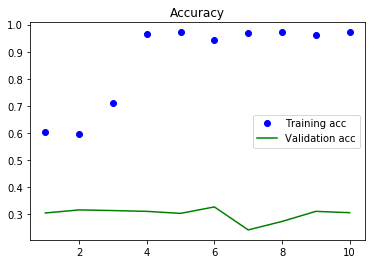

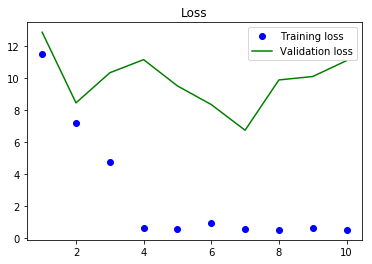

In [32]:
plot_acc_val(history)